# Fuzzy Suitability Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from rasterio.enums import Resampling
import numpy as np

from rtree import index

# from rasterio.features import geometry_mask
from scipy.spatial import distance
import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize

### Load data

In [2]:
farm = gpd.read_file(r"./raster/clip_farm.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (249005.828 481581.281)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,526231,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,613.0,POINT (248872.015 480167.536)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,527052,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,625.0,POINT (246452.085 483617.636)
3,NaN,Rijksbeschermd,NaN,Ja,9916,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,652.0,POINT (248704.433 479914.870)
4,NaN,Gemeentelijk monument,NaN,Ja,BOR01032,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,671.0,POINT (248663.461 480092.868)


In [3]:
road = gpd.read_file(r"./raster/clip_road.shp")
road.head()

,u,v,key,highway,geometry
0,356,391,0,motorway,"LINESTRING (247574.767 478133.761, 247574.751 ..."
1,356,392,0,motorway_link,"LINESTRING (247703.431 478197.122, 247710.942 ..."
2,388,501,0,secondary,"LINESTRING (244106.110 481570.317, 244127.141 ..."
3,391,430,0,motorway_link,"LINESTRING (247106.336 478783.924, 247078.913 ..."
4,391,422,0,motorway,"LINESTRING (247106.336 478783.924, 247078.025 ..."


In [4]:
road = road.to_crs("EPSG:28992")

In [5]:
lu = rasterio.open(r'./raster/agri_clip.tif')

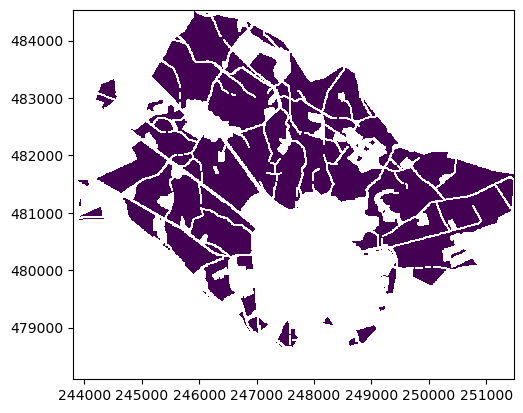

<Axes: >

In [6]:
show(lu)

In [7]:
lu.count

1

In [8]:
print(lu.width, lu.height)

768 644


In [9]:
lu.indexes

(1,)

In [10]:
band1 = lu.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
band1[lu.height // 2, lu.width // 2]

4

In [12]:
lu.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 768,
 'height': 644,
 'count': 1,
 'crs': CRS.from_epsg(28992),
 'transform': Affine(10.0, 0.0, 243799.6719999984,
        0.0, -10.0, 484538.0309999995)}

In [13]:
# Load raster data
with rasterio.open(r'./raster/agri_clip.tif') as src:
    LU = src.read(1)  # Assuming it is a single band raster

In [14]:
LU.shape

(644, 768)

### Calculate distances

In [85]:
# Initialize an empty array to store the distances
distances_farm = np.ones_like(LU) * np.inf

In [86]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        cell_center = src.xy(row, col)
        point = Point(cell_center)

        # Calculate distances to farms
        for _, f in farm.iterrows():
            distance = point.distance(f.geometry)
            if distance < distances_farm[row, col]:
                distances_farm[row, col] = distance

In [90]:
distances_farm.shape

(644, 768)

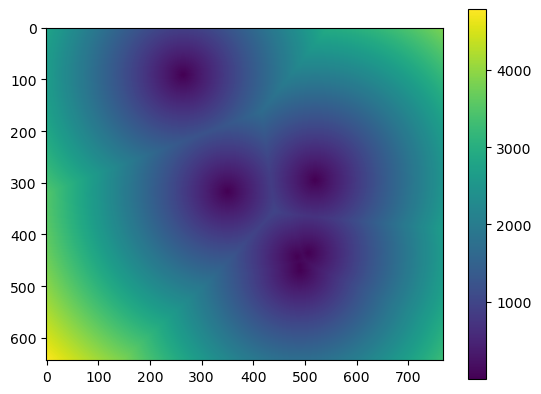

In [98]:
# Combine the distances with the original raster data
combined_raster = LU + distances_farm

# Visualize the combined raster
plt.imshow(combined_raster, cmap='viridis')
plt.colorbar()
plt.show()

In [104]:
distances_farm

array([[2801.20381912, 2791.75474907, 2782.30953017, ..., 3835.31828744,
        3841.71097946, 3848.11903837],
       [2797.95191824, 2788.49182884, 2779.03552014, ..., 3827.62738057,
        3834.03289608, 3840.45376642],
       [2794.7320153 , 2785.26098957, 2775.79367438, ..., 3819.94716756,
        3826.36554013, 3832.79925517],
       ...,
       [4774.41451472, 4767.07176396, 4759.73869525, ..., 3234.35668362,
        3242.84555723, 3251.34302392],
       [4781.20345713, 4773.87114854, 4766.54854032, ..., 3239.66046203,
        3248.13547445, 3256.61913824],
       [4788.003659  , 4780.68178014, 4773.36961981, ..., 3244.98638851,
        3253.44752728, 3261.9173754 ]])

### Rtree method

In [15]:
# Create spatial indexes for farms and roads
idx_farms = index.Index()
for i, f in farm.iterrows():
    idx_farms.insert(i, f.geometry.bounds)

In [16]:
# Create a mask to identify non-background values
background_value = 0  # Adjust this if the background value is different
mask = LU != background_value

In [17]:
d_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [18]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

        # Calculate distances to nearby farms using spatial indexing
            for j in idx_farms.nearest(cell_center, 1):
                f = farm.geometry.iloc[j]
                d = point.distance(f)
                if d < d_to_farm[row, col]:
                    d_to_farm[row, col] = d

In [105]:
# (distances_farm==distances_f).all() 

True

In [19]:
d_to_farm

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [36]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_farm.tif', 'w', **profile) as dst:
        dst.write(d_to_farm, 1)

In [37]:
d_to_farm_raster = rasterio.open(r'./raster/d_to_farm.tif')

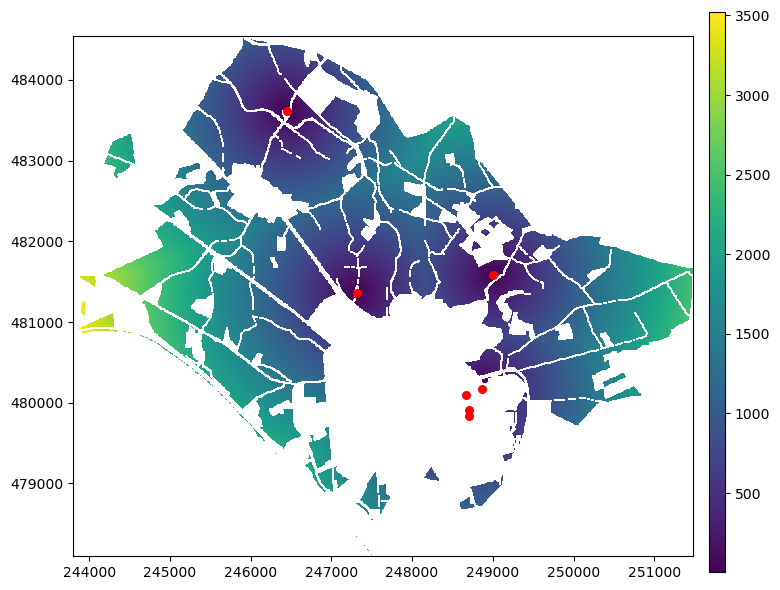

In [41]:
# Plot the raster
fig, ax = plt.subplots(figsize=(8, 8))
show(d_to_farm_raster, ax=ax)

# Plot the farms
farm.plot(ax=ax, marker='o', color='red', markersize=30)

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(ax.get_images()[0], cax=cax)

# Show the plot
plt.show()

In [42]:
# if np.any(lu.read(1) > 0):
#     print("There are values larger than zero in the array.")
# else:
#     print("There are no values larger than zero in the array.")